In [ ]:
%matplotlib inline
#!/usr/bin/python
#from __future__ import unicode_literals""""""

In [ ]:
455488+455961+455927+53113

1420489

In [ ]:
!pip install transformers==2.9.0
import os
import re
import sys
import random
from copy import deepcopy
import string
from collections import Counter
import math
import time
import pickle
import ast
import collections as C
import copy
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.model_selection import *
from sklearn.metrics import *
from matplotlib import pyplot as plt
from ast import literal_eval
import transformers
import seaborn as sns
from transformers import *

     |████████████████████████████████| 645kB 5.4MB/s 
     |████████████████████████████████| 3.8MB 28.9MB/s 
     |████████████████████████████████| 890kB 56.5MB/s 
     |████████████████████████████████| 1.1MB 58.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=195b9d1940fb7b0d7ed4bc90c4cbc83649c7ca8a26683413d84c0b131d52cb24
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,LSTM,Concatenate,TimeDistributed
from tensorflow.keras.layers import Subtract,Lambda,Add,Conv1D,Dot
#from tensorflow.keras.utils.vis_utils import model_to_dot	
from tensorflow.keras.utils import plot_model,to_categorical
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


## Load SST

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.dev
!wget https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.phrases.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.test

--2020-09-21 13:47:04--  https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.dev
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.dev [following]
--2020-09-21 13:47:05--  https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117239 (114K) [text/plain]
Saving to: ‘stsa.fine.dev’

stsa.fine.dev       100%[===================>] 114.49K  --.-KB/s    in 0.02s   

2020-09-21 13:47:05 (4.88 MB/s) - ‘stsa.fine.dev’ saved [117239/117239]

--2020-09-21 13:47:0

In [ ]:
DPATH="./"
train=open(DPATH+"stsa.fine.train","r",encoding="ISO-8859-1").readlines()
test=open(DPATH+"stsa.fine.test","r",encoding="ISO-8859-1").readlines()
dev=open(DPATH+"stsa.fine.dev","r",encoding="ISO-8859-1").readlines()
phras=open(DPATH+"stsa.fine.phrases.train","r",encoding="ISO-8859-1").readlines()
train=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in train]
test=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in test]
dev=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in dev]
phras=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in phras]
trainlabels,traindata=list(zip(*train))
testlabels,testdata=list(zip(*test))
devlabels,devdata=list(zip(*dev))

In [ ]:
train_sentences = traindata
test_sentences = testdata
dev_sentences = devdata

In [ ]:
train_labels = trainlabels
test_labels = testlabels
dev_labels = devlabels

In [ ]:
#train_labels

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
max_sentence_length = max(sentence_lengths)
print("Maximum Sentence Length: {} ".format(max_sentence_length))
train_sentence = train_sentences
dev_sentence = dev_sentences
print("Training Data Size: {} ".format(len(train_sentence)))
print("Validation Data Size: {} ".format(len(dev_sentence)))

Maximum Sentence Length: 52 
Training Data Size: 8544 
Validation Data Size: 1101 


## Tokenize

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional, Input
from tensorflow.keras.layers import Subtract,Lambda,Add,Conv1D,Reshape,Dropout,Permute
from transformers import BertTokenizer, TFBertForSequenceClassification,TFBertModel, TFDistilBertModel, DistilBertTokenizer, TFAlbertModel , AlbertTokenizer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model,to_categorical

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
T=55

def tokenize_sentences(sentences,T=30):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  tokenized_sentences=[]
  for sentence in sentences:
    encoded = bert_tokenizer.encode_plus(text=sentence,
                                        add_special_tokens=True,
                                        max_length=T,
                                        pad_to_max_length=True,
                                        return_attention_masks=True,
                                        return_token_type_ids=True)
    tokenized_sentence = bert_tokenizer.convert_ids_to_tokens(encoded['input_ids'])
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])
    tokenized_sentences.append(tokenized_sentence)
  #print(len(input_ids))
  #input_ids = torch.cat(input_ids, dim=0, out=None)
  #attention_masks = torch.cat(attention_masks, dim=0, out=None)
  #token_type_ids = torch.cat(token_type_ids, dim=0, out=None)
  input_ids = np.array(input_ids)
  attention_masks = np.array(attention_masks)
  token_type_ids = np.array(token_type_ids)

  return input_ids, attention_masks, token_type_ids,tokenized_sentences

In [ ]:
train_input_ids, train_attention_masks, train_token_type_ids,_ = tokenize_sentences(train_sentences,T)
dev_input_ids, dev_attention_masks, dev_token_type_ids,_ = tokenize_sentences(dev_sentences,T)
test_input_ids, test_attention_masks, test_token_type_ids,_ = tokenize_sentences(test_sentences,T)

In [ ]:
train_attention_masks[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_token_type_ids[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("First Sentence: ", train_sentence[0],train_input_ids[0],train_attention_masks[0],train_token_type_ids[0])

First Sentence:  a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films [  101  1037 18385  1010  6057  1998  2633 18276  2128  1011 16603  1997
  5053  1998  1996  6841  1998  5687  5469  3152   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## BERT Model

In [ ]:
def bert_model(T):
  model_base = TFBertModel.from_pretrained('bert-base-uncased',output_hidden_states=True,output_attentions=True)
  In=Input(shape=(T,),name="Input_Sentence",dtype=np.int64)
  At=Input(shape=(T,),name="Attention_Mask",dtype=np.int64)
  To=Input(shape=(T,),name="Token_Type",dtype=np.int64)
  ############################
  o1,o2,o3,o4=model_base([In,At,To])
  ##########################
  #o = K.stack(o3,axis=-1)
  #o=tf.convert_to_tensor(o)
  #print(o.shape)
  #o = Permute((1,3,2))(o)
  #o=o[:,0,:,:]
  #o=o[:,1:,:]# since first is embedding
  #o=LSTM(64,return_sequences=False)(o)
  o=Dropout(0.1)(o1[:,0,:])
  o=Dense(5,activation="softmax")(o)##################### MENTION number of classes
  model_o=Model(inputs=[In,At,To],outputs=[o])
  attentionmodel=Model(inputs=[In,At,To],outputs=[o4])
  return model_o,attentionmodel

In [ ]:
m1,m2=bert_model(T)
m1.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
Attention_Mask (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
Token_Type (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 55, 768), (N 109482240   Input_Sentence[0][0]             
                                                                 Attention_Mask[0][0] 

In [ ]:
#train_input_ids, train_attention_masks, train_token_type_ids,train_tokenized_sentences = tokenize_sentences(train_sentence, train_aspect,T=T)
#dev_input_ids, dev_attention_masks, dev_token_type_ids,dev_tokenized_sentences = tokenize_sentences(dev_sentence, dev_aspect,T=T)
#test_input_ids, test_attention_masks, test_token_type_ids,test_tokenized_sentences = tokenize_sentences(test_sentence, test_aspect,T=T)

## Training

In [ ]:
train_labels_categorical = to_categorical(train_labels)
dev_labels_categorical  = to_categorical(dev_labels)
test_labels_categorical  = to_categorical(test_labels)

In [ ]:
e=10
lr=5e-5 # 1e-5, 2e-5, 5e-5
custom_adam = tf.keras.optimizers.Adam(learning_rate=lr,epsilon=1e-8,decay=0.01)

In [ ]:
"""
def fit_model(XX,yy,model,verbose=0,epochs=e):
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer=custom_adam)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=8,validation_data=([dev_input_ids, dev_attention_masks, dev_token_type_ids],dev_labels_categorical),callbacks=[es],verbose=verbose)
  return model,history
"""
def fit_model(XX,yy,model,verbose=0,epochs=e):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer=custom_adam)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=8,validation_data=([dev_input_ids, dev_attention_masks, dev_token_type_ids],dev_labels_categorical),callbacks=[es],verbose=verbose)
  return model,history

In [ ]:
print(train_input_ids.shape,train_labels_categorical.shape,test_input_ids.shape, test_labels_categorical.shape,dev_input_ids.shape, dev_labels_categorical.shape)

(8544, 55) (8544, 5) (2210, 55) (2210, 5) (1101, 55) (1101, 5)


In [ ]:
#X_train=X_train[:1000]
#Xs_train=Xs_train[:1000]
#y_train=y_train[:1000]
#X_test=X_test[:500]
#y_test=y_test[:500]

In [ ]:
def indexer(test_list,index_list,nparr=True):
  if nparr==True:
    return np.array([test_list[i] for i in index_list])
  else:
    return [test_list[i] for i in index_list]

In [ ]:
# till here skip

## Non Curriculum

Epoch 1/25
1068/1068 [==============================] - 81s 76ms/step - loss: 1.2041 - acc: 0.4710 - val_loss: 1.1142 - val_acc: 0.5095
Epoch 2/25
1068/1068 [==============================] - 78s 73ms/step - loss: 0.9210 - acc: 0.6037 - val_loss: 1.1404 - val_acc: 0.5041
Epoch 3/25
1068/1068 [==============================] - 78s 73ms/step - loss: 0.8124 - acc: 0.6564 - val_loss: 1.1874 - val_acc: 0.5032
Epoch 4/25
1068/1068 [==============================] - 78s 73ms/step - loss: 0.7487 - acc: 0.6840 - val_loss: 1.2441 - val_acc: 0.5005
Epoch 5/25
1068/1068 [==============================] - 78s 73ms/step - loss: 0.6998 - acc: 0.7162 - val_loss: 1.2884 - val_acc: 0.5059
Epoch 6/25
1068/1068 [==============================] - 78s 73ms/step - loss: 0.6629 - acc: 0.7308 - val_loss: 1.3179 - val_acc: 0.4959
Epoch 00006: early stopping
70/70 [==============================] - 5s 77ms/step - loss: 1.0655 - acc: 0.5262
[0.5262443423271179]


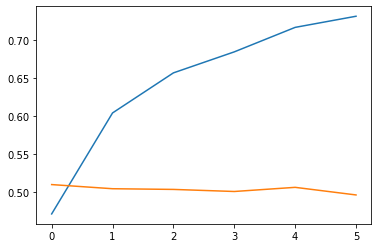

In [ ]:
seed=0
ncc=[]
modelspairs=[]
for i in np.arange(1):
  tf.random.set_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  model_o,atten_model = bert_model(T)
  model_o,history = fit_model([train_input_ids, train_attention_masks, train_token_type_ids],train_labels_categorical,model_o,verbose=1,epochs=25)
  ncc.append(model_o.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  print(ncc)
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.show()
  modelspairs.append([model_o,atten_model])
NC=np.mean(ncc)

In [ ]:
NC=np.mean(ncc)

In [ ]:
ncc, NC 

([0.5262443423271179], 0.5262443423271179)

## Cross Review Method

In [ ]:
print(train_input_ids.shape,train_labels_categorical.shape,test_input_ids.shape, test_labels_categorical.shape,dev_input_ids.shape, dev_labels_categorical.shape)

(8544, 55) (8544, 5) (2210, 55) (2210, 5) (1101, 55) (1101, 5)


In [ ]:
indicies = np.arange(len(train_input_ids))

In [ ]:
(train_input_ids).shape[0]

8544

In [ ]:
n=5
temp = list(np.arange(train_input_ids.shape[0]))
np.random.seed(1)
np.random.shuffle(temp)
#random_indicies = random.shuffle(list(np.arange(train_input_ids.shape[0])))# Divide into n
n_train_sets = np.array_split(temp,n)

Nth Set Training 1709 0
datapoints to be searched from this iteration and trained on 1709 datapoints
Epoch 1/30
214/214 [==============================] - 25s 115ms/step - loss: 1.6275 - acc: 0.2879 - val_loss: 1.5102 - val_acc: 0.3506
Epoch 2/30
214/214 [==============================] - 22s 105ms/step - loss: 1.4832 - acc: 0.3581 - val_loss: 1.4462 - val_acc: 0.3978
Epoch 3/30
214/214 [==============================] - 22s 104ms/step - loss: 1.3893 - acc: 0.4266 - val_loss: 1.3921 - val_acc: 0.4051
Epoch 4/30
214/214 [==============================] - 22s 104ms/step - loss: 1.2880 - acc: 0.4611 - val_loss: 1.3360 - val_acc: 0.4151
Epoch 5/30
214/214 [==============================] - 23s 106ms/step - loss: 1.2329 - acc: 0.4734 - val_loss: 1.3012 - val_acc: 0.4223
Epoch 6/30
214/214 [==============================] - 23s 105ms/step - loss: 1.1879 - acc: 0.5003 - val_loss: 1.2840 - val_acc: 0.4242
Epoch 7/30
214/214 [==============================] - 22s 104ms/step - loss: 1.1252 - acc

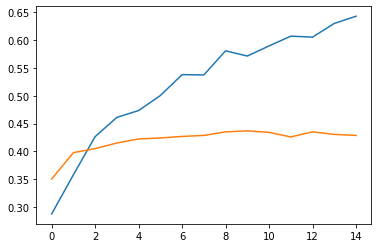

Nth Set Training 1709 1
datapoints to be searched from this iteration and trained on 1709 datapoints
Epoch 1/30
214/214 [==============================] - 25s 115ms/step - loss: 1.6718 - acc: 0.2686 - val_loss: 1.5436 - val_acc: 0.3215
Epoch 2/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5399 - acc: 0.3388 - val_loss: 1.4985 - val_acc: 0.3488
Epoch 3/30
214/214 [==============================] - 22s 105ms/step - loss: 1.4784 - acc: 0.3640 - val_loss: 1.4601 - val_acc: 0.3678
Epoch 4/30
214/214 [==============================] - 23s 105ms/step - loss: 1.4289 - acc: 0.3967 - val_loss: 1.4214 - val_acc: 0.3896
Epoch 5/30
214/214 [==============================] - 22s 104ms/step - loss: 1.3676 - acc: 0.4365 - val_loss: 1.3859 - val_acc: 0.3915
Epoch 6/30
214/214 [==============================] - 22s 104ms/step - loss: 1.3261 - acc: 0.4342 - val_loss: 1.3569 - val_acc: 0.4078
Epoch 7/30
214/214 [==============================] - 22s 104ms/step - loss: 1.2707 - acc

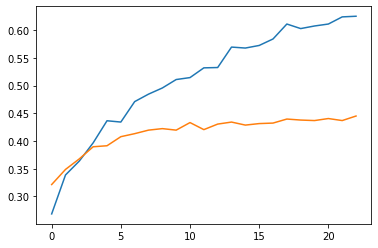

Nth Set Training 1709 2
datapoints to be searched from this iteration and trained on 1709 datapoints
Epoch 1/30
214/214 [==============================] - 24s 114ms/step - loss: 1.7159 - acc: 0.2341 - val_loss: 1.5730 - val_acc: 0.3034
Epoch 2/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5842 - acc: 0.2885 - val_loss: 1.5482 - val_acc: 0.3243
Epoch 3/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5683 - acc: 0.3002 - val_loss: 1.5215 - val_acc: 0.3397
Epoch 4/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5227 - acc: 0.3329 - val_loss: 1.5041 - val_acc: 0.3479
Epoch 5/30
214/214 [==============================] - 22s 104ms/step - loss: 1.4902 - acc: 0.3406 - val_loss: 1.4832 - val_acc: 0.3542
Epoch 6/30
214/214 [==============================] - 22s 104ms/step - loss: 1.4673 - acc: 0.3634 - val_loss: 1.4630 - val_acc: 0.3742
Epoch 7/30
214/214 [==============================] - 22s 104ms/step - loss: 1.4450 - acc

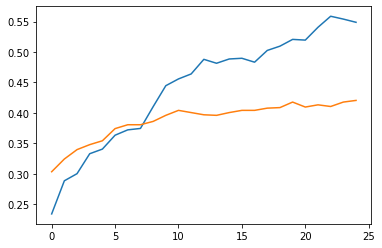

Nth Set Training 1709 3
datapoints to be searched from this iteration and trained on 1709 datapoints
Epoch 1/30
214/214 [==============================] - 24s 114ms/step - loss: 1.7411 - acc: 0.2481 - val_loss: 1.5904 - val_acc: 0.2897
Epoch 2/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5882 - acc: 0.2891 - val_loss: 1.5687 - val_acc: 0.3015
Epoch 3/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5717 - acc: 0.2978 - val_loss: 1.5478 - val_acc: 0.3243
Epoch 4/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5391 - acc: 0.3259 - val_loss: 1.5341 - val_acc: 0.3279
Epoch 5/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5090 - acc: 0.3388 - val_loss: 1.5190 - val_acc: 0.3388
Epoch 6/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5022 - acc: 0.3411 - val_loss: 1.5052 - val_acc: 0.3379
Epoch 7/30
214/214 [==============================] - 22s 104ms/step - loss: 1.4781 - acc

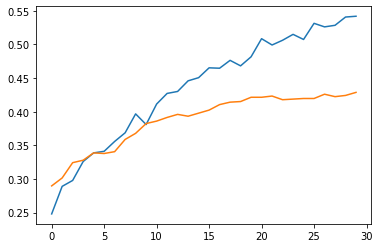

Nth Set Training 1708 4
datapoints to be searched from this iteration and trained on 1708 datapoints
Epoch 1/30
214/214 [==============================] - 25s 115ms/step - loss: 1.7823 - acc: 0.2313 - val_loss: 1.6099 - val_acc: 0.2652
Epoch 2/30
214/214 [==============================] - 22s 104ms/step - loss: 1.6196 - acc: 0.2787 - val_loss: 1.5867 - val_acc: 0.2997
Epoch 3/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5954 - acc: 0.3004 - val_loss: 1.5675 - val_acc: 0.3079
Epoch 4/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5595 - acc: 0.3103 - val_loss: 1.5560 - val_acc: 0.3152
Epoch 5/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5452 - acc: 0.3150 - val_loss: 1.5451 - val_acc: 0.3224
Epoch 6/30
214/214 [==============================] - 22s 104ms/step - loss: 1.5309 - acc: 0.3454 - val_loss: 1.5333 - val_acc: 0.3297
Epoch 7/30
214/214 [==============================] - 23s 105ms/step - loss: 1.5322 - acc

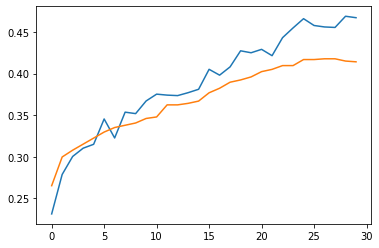

CPU times: user 38min 35s, sys: 6min 48s, total: 45min 23s
Wall time: 47min 14s


In [ ]:
%%time
seed=0
models_list=[]
for i,nth_train_set in enumerate(n_train_sets):
  print("Nth Set Training",len(nth_train_set),i)
  tf.random.set_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  a = indexer(train_input_ids,nth_train_set)
  b = indexer(train_attention_masks,nth_train_set)
  c = indexer(train_token_type_ids,nth_train_set)
  y = indexer(train_labels_categorical,nth_train_set)
  print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
  model1,atten_model = bert_model(T)
  model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=30)
  models_list.append(model1)
  ###
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.show()

In [ ]:
total_performance=[]
for i,model in enumerate(models_list):
  print('Testing',i+1)
  out  = model.predict([train_input_ids,train_attention_masks, train_token_type_ids]) #train_labels_categorical[i])
  performance = (np.argmax(out,axis=-1) == np.argmax(train_labels_categorical,axis=-1)).astype(int)
  total_performance.append(performance)
  print(np.sum(performance)/len(performance))

Testing 1
0.5021067415730337
Testing 2
0.49754213483146065
Testing 3
0.4830290262172285
Testing 4
0.4790496254681648
Testing 5
0.45915262172284643


In [ ]:
#scores = np.random.randint(0,5,train_input_ids.shape[0])

In [ ]:
scores = np.sum(total_performance,axis=0)

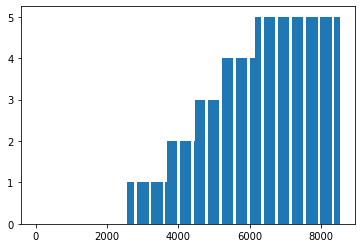

In [ ]:
plt.bar(np.arange(len(scores)),sorted(scores))
sorted_indices=[x for _, x in sorted(zip(scores,np.arange(len(scores))), key=lambda pair: pair[0],reverse=False)]

In [ ]:
n

5

In [ ]:
sorted_labels = indexer(train_labels,sorted_indices)

In [ ]:
sorted_sentences = indexer(train_sentences, sorted_indices)

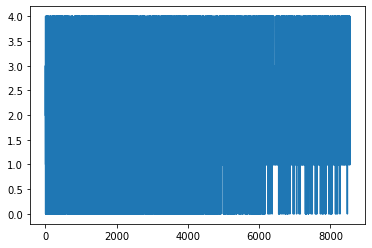

In [ ]:
plt.plot((sorted_labels))

In [ ]:
sorted_sentences = indexer(train_sentences,sorted_indices)

In [ ]:
sorted_sentences_labels = [[j,sorted_labels[i]] for i,j in enumerate(sorted_sentences)]

In [ ]:
#sorted_sentences_labels[:50]#sorted_sentences_labels[-50:]

In [ ]:
np.array([1,2,3,4]).take([0,3])

array([1, 4])

In [ ]:
sorted_scores = np.array(sorted(scores))
n_sorted_arrays = [np.array(sorted_indices).take([np.where(sorted_scores==i)])[0][0] for i in np.arange(n)]
print([len(i) for i in n_sorted_arrays])

[2564, 1125, 786, 683, 992]


## Fetch Examples of Hard and Easy

In [ ]:
with open("sorted_indices.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in sorted_indices))

with open("sorted_sentences.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in sorted_sentences))


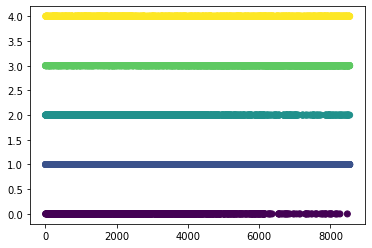

In [ ]:
#_,_ = plt.figsize(1,3)
plt.scatter(np.arange(len(sorted_labels)),sorted_labels,c=sorted_labels)

In [ ]:
sorted_sentences = indexer(train_sentences,sorted_indices)

In [ ]:
short_train_input_ids = indexer(train_input_ids,sorted_indices[:5])
short_train_attention_masks = indexer(train_attention_masks,sorted_indices[:5])
short_train_token_type_ids = indexer(train_token_type_ids,sorted_indices[:5])
short_train_labels_categorical = indexer(train_labels_categorical,sorted_indices[:5])

In [ ]:
#model.predict([short_train_input_ids, short_train_attention_masks, short_train_token_type_ids]) , short_train_labels_categorical

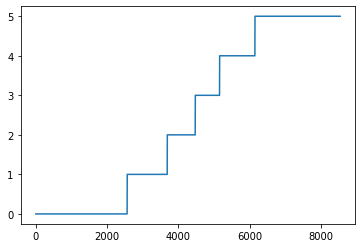

In [ ]:
plt.plot(sorted(scores))

##### Annealing Original

In [ ]:
n=int(len(sorted_indices)/1600)
print(n)

5


###### Create N sets

In [ ]:
s= sorted(scores)
for i,j in enumerate(sorted_sentences):
  s[i]!=s[i-1]
  

###### Create NewSet

In [ ]:
newsets=[]
#temp=np.arange(50)+1
temp=sorted_indices
n=5
big_sets = n_sorted_arrays##### take non equal sized big arrays
all_sets = np.array([np.array_split(np.random.permutation(d),n) for d in big_sets])
for it1 in np.arange(n):
  newitem=[]
  for it2 in np.arange(it1+1):
    #print(it1-it2,it2)
    newitem = newitem+ list(all_sets[it1-it2][it2])
  #print("-----")
  newsets.append(newitem)
assert len(set.intersection(*map(set,newsets))) == 0
[len(i) for i in newsets]

[513, 738, 896, 1032, 1230]

In [ ]:
import gc
gc.collect()

583188

###### Training all Equal epochs

datapoints to be searched from this iteration and trained on 513 datapoints
Epoch 1/8
65/65 [==============================] - 12s 190ms/step - loss: 1.9923 - acc: 0.2924 - val_loss: 1.9810 - val_acc: 0.2053
Epoch 2/8
65/65 [==============================] - 10s 155ms/step - loss: 1.7894 - acc: 0.2963 - val_loss: 1.8608 - val_acc: 0.2025
Epoch 3/8
65/65 [==============================] - 10s 155ms/step - loss: 1.7444 - acc: 0.2749 - val_loss: 1.8119 - val_acc: 0.2044
Epoch 4/8
65/65 [==============================] - 10s 154ms/step - loss: 1.7106 - acc: 0.2632 - val_loss: 1.7866 - val_acc: 0.2053
Epoch 5/8
65/65 [==============================] - 10s 155ms/step - loss: 1.6838 - acc: 0.2827 - val_loss: 1.7834 - val_acc: 0.2025
Epoch 6/8
65/65 [==============================] - 10s 154ms/step - loss: 1.6915 - acc: 0.2671 - val_loss: 1.7737 - val_acc: 0.1998
Epoch 7/8
65/65 [==============================] - 10s 155ms/step - loss: 1.6286 - acc: 0.2904 - val_loss: 1.7676 - val_acc: 0.1971


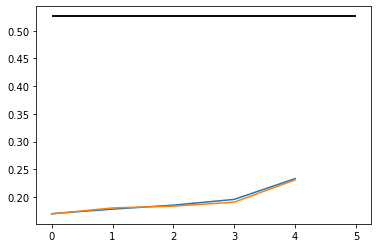

In [ ]:
seed=0
growth_list=[]
for nn in np.arange(2):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=8)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

array([[0.16968326, 0.17782806, 0.18506788, 0.19547512, 0.23303168],
       [0.16923077, 0.1800905 , 0.18325792, 0.19049774, 0.23076923]])

In [ ]:
growth_list

array([[0.16968326, 0.17782806, 0.18506788, 0.19547512, 0.23303168],
       [0.16923077, 0.1800905 , 0.18325792, 0.19049774, 0.23076923]])

###### Training More like the original Paper

Which is to train on all sets for 1 epoch followed by combined training untill saturation

[513, 738, 896, 1032, 1230, 8544]
datapoints to be searched from this iteration and trained on 513 datapoints
70/70 [==============================] - 5s 77ms/step - loss: 2.0929 - acc: 0.1719
datapoints to be searched from this iteration and trained on 738 datapoints
70/70 [==============================] - 5s 77ms/step - loss: 1.8612 - acc: 0.1706
datapoints to be searched from this iteration and trained on 896 datapoints
70/70 [==============================] - 5s 77ms/step - loss: 1.7804 - acc: 0.1729
datapoints to be searched from this iteration and trained on 1032 datapoints
70/70 [==============================] - 5s 77ms/step - loss: 1.7145 - acc: 0.1787
datapoints to be searched from this iteration and trained on 1230 datapoints
70/70 [==============================] - 5s 77ms/step - loss: 1.6688 - acc: 0.1878
datapoints to be searched from this iteration and trained on 8544 datapoints
Epoch 1/25
1068/1068 [==============================] - 81s 76ms/step - loss: 1.6271 - acc: 

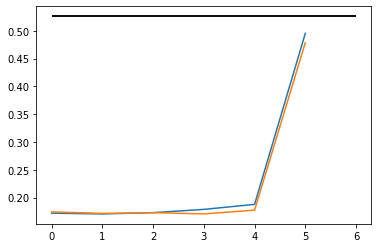

In [ ]:
newsets_updated = deepcopy(newsets)
newsets_updated.append(sorted_indices)# End with the whole data
print([len(i) for i in newsets_updated])
seed=0
Batch_size=1600
growth_list=[]
for nn in np.arange(2):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets_updated):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    if len(a)!=len(sorted_indices):
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=1)
    else:
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=25)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

array([[0.17194571, 0.17058824, 0.17285068, 0.17873304, 0.18778281,
        0.49547511],
       [0.17420815, 0.17149322, 0.17285068, 0.17058824, 0.17737557,
        0.47873303]])

##### Annealing Updated (New Idea 1)

###### Create NewSet

In [ ]:
from itertools import islice
from itertools import accumulate  
newsets=[]

n=5

arr=sorted_indices
ratios=np.arange(n)[::-1] + 1
new_ratios = ((np.array(ratios)/sum(ratios))*len(arr)).astype(np.int32)
diff = np.abs(len(arr) - sum(new_ratios))
new_ratios[-1 ] = new_ratios[-1 ] + diff
length_to_split = list(new_ratios)
print(diff,length_to_split)
#

big_sets = [arr[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
all_sets = np.array([np.array_split(np.random.permutation(d),n-i) for i,d in enumerate(big_sets)])
all_sets[:4]
for it1 in np.arange(n):
  newitem=[]
  for it2 in np.arange(it1+1):
    #print(it1-it2,it2)
    newitem = newitem+ list(all_sets[it1-it2][it2])
  #print("-----")
  newsets.append(newitem)
assert len(set.intersection(*map(set,newsets))) == 0
print([len(i) for i in newsets])

###### Training all Equal epochs

In [ ]:
seed=1
growth_list=[]
for nn in np.arange(2):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=9)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

###### Training More like the original Paper

In [ ]:
newsets_updated = deepcopy(newsets)
newsets_updated.append(sorted_indices)# End with the whole data
print([len(i) for i in newsets_updated])
seed=0
Batch_size=1600
growth_list=[]
for nn in np.arange(2):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets_updated):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    if len(a)!=len(sorted_indices):
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=1)
    else:
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=50)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

##### Annealing Updated (New Idea 2)

In [ ]:
n=int(len(sorted_indices)/1600)
print(n)

In [ ]:
np.arange(1)
#    newitem = big_sets[it1-it2][it2]
#    big_sets[0][0]
#    big_sets[1][0] + big_sets[0][1]
#    big_sets[2][0] + big_sets[1][1] + big_sets[0][2]
#    big_sets[3][0] + big_sets[2][1] + big_sets[1][2] + big_sets[0][3]

In [ ]:
#set.intersection([[1,2],[2,3]])

###### Create NewSet

In [ ]:
newsets=[]
#temp=np.arange(50)+1
temp=sorted_indices
n=5
big_sets = np.array_split(temp,n)
all_sets = np.array([np.array_split(np.random.permutation(d),n-i) for i,d in enumerate(big_sets)])
all_sets[:4]
for it1 in np.arange(n):
  newitem=[]
  for it2 in np.arange(it1+1):
    #print(it1-it2,it2)
    newitem = newitem+ list(all_sets[it1-it2][it2])
  #print("-----")
  newsets.append(newitem)
assert len(set.intersection(*map(set,newsets))) == 0
[len(i) for i in newsets]

###### Training all Equal epochs

In [ ]:
seed=0
growth_list=[]
for nn in np.arange(7):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=10)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

###### Training More like the original Paper

In [ ]:
newsets_updated = deepcopy(newsets)
newsets_updated.append(sorted_indices)# End with the whole data
print([len(i) for i in newsets_updated])
seed=0
Batch_size=1600
growth_list=[]
for nn in np.arange(7):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(newsets_updated):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    if len(a)!=len(sorted_indices):
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=1)
    else:
      model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=50)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
growth_list

# OLD/Rough

##### BABY STEPS

In [ ]:
 #np.array_split(sorted_indices,n)

In [ ]:
seed=0
Batch_size=1600
growth_list=[]
for nn in np.arange(2):
  n=int(len(sorted_indices)/Batch_size)
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(np.array_split(sorted_indices,n)):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    newa.extend(a)
    newb.extend(b)
    newc.extend(c)
    newy.extend(y)
    print("datapoints to be searched from this iteration and trained on",len(newa),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(newa),np.array(newb),np.array(newc)],np.array(newy),model1,verbose=1,epochs=10)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
from copy import deepcopy
seed=0
Batch_size=1600
growth_list=[]
models=[]
for nn in np.arange(1):
  n=int(len(sorted_indices)/Batch_size)
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(np.array_split(sorted_indices,n)): 
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    newa.extend(a)
    newb.extend(b)
    newc.extend(c)
    newy.extend(y)
    print("datapoints to be searched from this iteration and trained on",len(newa),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(newa),np.array(newb),np.array(newc)],np.array(newy),model1,verbose=1,epochs=10)
    ###
    model1.save_weights("baby"+str(iter)+".h5")
    #models.append(yeah but(model1))
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  growth_list.append(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
growth_list=np.array(growth_list)
plt.show()

In [ ]:
len(models)

In [ ]:
baby_pass_models = models

In [ ]:
bs_growth  = np.mean(growth_list,axis=0)
bs_growth

In [ ]:
model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)

In [ ]:
!zip baby.zip baby0.h5 baby1.h5 baby2.h5 baby3.h5 baby4.h5

In [ ]:
!ls -lah

#### ONE PASS

In [ ]:
"""#Batch_size=1700
n=int(len(sorted_indices)/Batch_size)
growth=[]
newX=[]
newy=[]
model1=my_model()
for batch_ind in np.array_split(sorted_indices,n):
  newX=indexer(X_train,batch_ind)
  newy=indexer(y_train,batch_ind)
  print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
  model1=fit_model(newX,newy,model1,verbose=0,epochs=30)
  growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
plt.plot(growth)
plt.hlines(NC,0, len(growth))"""

In [ ]:
seed=0
Batch_size=1600#2000
n=int(len(sorted_indices)/Batch_size)
growth_list = []
for nn in np.arange(1):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  model1,atten_model1=bert_model(T)
  for iter,batch_ind in enumerate(np.array_split(sorted_indices,n)):
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(a),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(a),np.array(b),np.array(c)],np.array(y),model1,verbose=1,epochs=10)
    model1.save_weights("one"+str(iter)+".h5")
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
  growth_list.append(growth)
plt.show()
growth_list=np.array(growth_list)

In [ ]:
op_growth  = np.mean(growth_list,axis=0)
op_growth

### Individual

In [ ]:
"""#Batch_size=1700
n=int(len(sorted_indices)/Batch_size)
growth=[]
for batch_ind in np.array_split(sorted_indices,n):
  model1=my_model()
  newX=indexer(X_train,batch_ind)
  newy=indexer(y_train,batch_ind)
  print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
  model1=fit_model(newX,newy,model1,verbose=0,epochs=30)
  growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
plt.plot(growth)
plt.hlines(NC,0, len(growth))"""

In [ ]:
Batch_size=2000
seed=0
n=int(len(sorted_indices)/Batch_size)
growth_list=[]
for runs in np.arange(5):
  growth=[]
  newa=[]
  newb=[]
  newc=[]
  newy=[]
  for batch_ind in np.array_split(sorted_indices,n):
    model1,atten_model1=bert_model(T)
    a = indexer(train_input_ids,batch_ind)
    b = indexer(train_attention_masks,batch_ind)
    c = indexer(train_token_type_ids,batch_ind)
    y = indexer(train_labels_categorical,batch_ind)
    newa.extend(a)
    newb.extend(b)
    newc.extend(c)
    newy.extend(y)
    print("datapoints to be searched from this iteration and trained on",len(newa),"datapoints")
    ####
    tf.random.set_seed(seed) 
    random.seed(seed)
    np.random.seed(seed)
    model1,history = fit_model([np.array(newa),np.array(newb),np.array(newc)],np.array(newy),model1,verbose=1,epochs=10)
    ###
    growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  plt.plot(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1])
  growth_list.append(growth)
plt.show()
growth_list=np.array(growth_list)

In [ ]:
i_growth  = np.mean(growth_list,axis=0)
i_growth

In [ ]:
plt.plot(op_growth)
plt.plot(bs_growth)
plt.plot(i_growth)

In [ ]:
op_growth, bs_growth, i_growth

In [ ]:
op_growth, bs_growth, i_growth(array([0.22533937, 0.26642535, 0.25945703, 0.22923077])
[0.2759276 , 0.34515838, 0.43710408, 0.48153847]
 [0.2316742092370987,
  0.2538461685180664,
  0.45972850918769836,
  0.4606334865093231,
  0.442533940076828])

### Analyize sorted_indices: Try sum_neutral Baby steps

In [ ]:
#traindata,trainlabels
#diff_neutral, sum_neutral, length, AdjCount

In [ ]:
tries=indexer(traindata,sorted_indices)

In [ ]:
plt.plot([sum_neutral(i) for i in tries])
plt.plot(sorted([sum_neutral(i) for i in tries],reverse=False))

In [ ]:
costs=[sum_neutral(i) for i in traindata]
sum_neutral_indices=[x for _, x in sorted(zip(costs,np.arange(len(costs))), key=lambda pair: pair[0],reverse=False)]

In [ ]:
#plt.plot(costs)
plt.plot([sum_neutral(traindata[i]) for i in sum_neutral_indices])

In [ ]:
for _ in np.arange(5):
  Batch_size=1000
  n=int(len(sum_neutral_indices)/Batch_size)
  growth=[]
  newX=[]
  newy=[]
  model1=my_model()
  for batch_ind in np.array_split(sum_neutral_indices,n):
    newX.extend(indexer(X_train,batch_ind))
    newy.extend(indexer(y_train,batch_ind))
    print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
    model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
    growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
  plt.plot(growth)
  print(growth[-1],growth[-2])
plt.hlines(NC,0,len(growth))
plt.show()

### Hyper Parameter: Batch_size *Tune*

In [ ]:
results=[]
batch_size_list=[750,800,850,900,950,1000,1500,2000]
batch_size_list=[500,750,800,950,1100,1200,1400,1550,1700]
#batch_size_list=[2000,3000]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  n=int(len(aux_sorted_indices)/batch_size)
  for _ in np.arange(3):
    growth=[]
    newX=[]
    newy=[]
    avg=[]
    model1=my_model()
    for batch_ind in np.array_split(aux_sorted_indices,n):
      newX.extend(indexer(X_train,batch_ind))
      newy.extend(indexer(y_train,batch_ind))
      #print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
      model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
      growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
    plt.plot(growth)
    print(growth[-1])
    avg.append(growth[-1])
    plt.hlines(NC,0, len(growth))
  plt.show()
  print(np.average(avg),NC)
  results.append(np.average(avg))

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,min(batch_size_list), max(batch_size_list))

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,min(batch_size_list), max(batch_size_list))

In [ ]:
results=[]
batch_size_list=[500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
batch_size_list=[750,800,850,900,950,1000,1500,2000]
batch_size_list=[500,800,1100,1400,1700,2000]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  randomval=[]
  for rand in np.arange(5):
    model=my_model()
    model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
    allindices=list(np.arange(len(X_train)))
    startt=1000
    start_indexes=master_order[:startt]
    newX=np.array(indexer(X_train,start_indexes))
    newy=np.array(indexer(y_train,start_indexes))
    top=startt-1
    ## half starting
    #newX=
    growth=[]
    while top+batch_size<len(X_train):
      #print("training on",len(newX),"datapoints")
      model = fit_model(newX,newy,model,epochs=30)
      t=model.evaluate(X_test,y_test,verbose=0)[1]
      #print(t,"performance on test data")
      growth.append(t)
      nextindex_list=master_order[top:top+batch_size]###i
      newX=np.concatenate([newX,np.  array(indexer(X_train,nextindex_list))])
      newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
      top=top+batch_size
    randomval.append(growth[-1])
  results.append(np.average(randomval))

#### One Pass

In [ ]:
avg=[]
Batch_size=1500
n=int(len(aux_sorted_indices)/Batch_size)
for _ in np.arange(2):
  growth=[]
  newX=[]
  newy=[]
  model1=my_model()
  for batch_ind in np.array_split(aux_sorted_indices,n):
    newX = indexer(X_train,batch_ind)
    newy = indexer(y_train,batch_ind)
    print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
    model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
    growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
  plt.plot(growth)
  print(growth[-1])
  avg.append(growth[-1])
  plt.hlines(NC,0, len(growth))
plt.show()
print(np.average(avg),NC)

In [ ]:
0.45565610859728506+0.4416289592760181+0.4416289592760181+0.45475113122171945+0.4425339366515837

In [ ]:
def length(sentence):
  return len(sentence.split(" "))
scores=[length(i) for i in traindata]
# master order is order of indices
master_order=sorted(range(len(scores)), key=lambda k: scores[k])
import seaborn as sns
sns.heatmap(np.array(sorted(scores,reverse=False)).reshape(1,len(scores)))

### Aux Task Sentiwordnet

In [ ]:
def feature(sentence):
  words=sentence.split(" ")
  l=len(words)
  pos=0
  neg=0
  obj=0
  for i in words:
    if score(i)!=False:
      p,n,o=score(i)
      #print(p,n,i)
      pos=pos+p
      neg=neg+n
      obj=obj+o
  return np.array([l,pos,neg,obj,np.abs(pos-neg),pos/l,neg/l,obj/l,np.abs(pos-neg)/l])### The Higher the Easier

In [ ]:
X_train_feat=np.array([feature(i) for i in traindata])
X_test_feat=np.array([feature(i) for i in testdata])
X_dev_feat=np.array([feature(i) for i in devdata])
X_train_feat.shape,X_test_feat.shape,X_dev_feat.shape

In [ ]:
#### Normalize aND Transform the vectors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_feat)
X_train_feat=scaler.transform(X_train_feat)
X_test_feat=scaler.transform(X_test_feat)
X_dev_feat = scaler.transform(X_dev_feat)

In [ ]:
I=Input(shape=(9,))
o=Dense(100,activation="relu")(I)
o=Dense(50,activation="relu")(o)
o=Dense(c,activation="softmax")(o)
aux_model=Model(inputs=I,outputs=o)
#aux_model.summary()
aux_model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10,restore_best_weights=True)
history=aux_model.fit(x=X_train_feat,y=y_train,epochs=25,batch_size=130,validation_data=[X_dev_feat,y_dev],callbacks=[es])
print(aux_model.evaluate(X_test_feat,y_test)[1])
def mse(y,y_hat):
  return np.sum(np.square(y-y_hat),axis=1)

costs=mse(aux_model.predict(X_train_feat),y_train)
aux_sorted_indices=[x for _, x in sorted(zip(costs,np.arange(len(costs))), key=lambda pair: pair[0],reverse=False)]
aux_model.predict(np.array(indexer(X_train_feat,aux_sorted_indices[:5]))) , indexer(y_train,aux_sorted_indices[:5])

In [ ]:
sns.heatmap(np.array(sorted(costs,reverse=False)).reshape(1,len(costs)))

#### Baby Steps Regular Code

In [ ]:
avg=[]
batch_size=1100#LSTM
batch_size=1400#cnn
batch_size=1100#atLSTM
n=int(len(aux_sorted_indices)/batch_size)
for _ in np.arange(10):
  growth=[]
  newX=[]
  newy=[]
  model1=my_model()
  for batch_ind in np.array_split(aux_sorted_indices,n):
    newX.extend(indexer(X_train,batch_ind))
    newy.extend(indexer(y_train,batch_ind))
    print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
    model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
    growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
  plt.plot(growth)
  print(growth[-1])
  avg.append(growth[-1])
  plt.hlines(NC,0, len(growth))
plt.show()
print(np.average(avg),NC)

## Curriculum: Sent Len

In [ ]:
traindata[0]

In [ ]:
def length(sentence):
  return len(sentence.split(" "))
scores=[length(i) for i in traindata]
scores=np.sum(train_attention_masks,axis=-1)
# master order is order of indices
master_order=sorted(range(len(scores)), key=lambda k: scores[k],reverse=True)
import seaborn as sns
sns.heatmap(np.array(sorted(scores,reverse=False)).reshape(1,len(scores)))

In [ ]:
#indexer(traindata,master_order)[:300]

### Regular **Code**

In [ ]:
Batch_size=1500

n=int(len(master_order)/Batch_size)
growth=[]
newa=[]
newb=[]
newc=[]
newy=[]
model1,atten_model1=bert_model(T)
for batch_ind in np.array_split(master_order,n):
  a = indexer(train_input_ids,batch_ind)
  b = indexer(train_attention_masks,batch_ind)
  c = indexer(train_token_type_ids,batch_ind)
  y = indexer(train_labels_categorical,batch_ind)
  newa.extend(a)
  newb.extend(b)
  newc.extend(c)
  newy.extend(y)
  print("datapoints to be searched from this iteration and trained on",len(newa),"datapoints")
  ####
  tf.random.set_seed(seed) 
  random.seed(seed)
  np.random.seed(seed)
  model1,history = fit_model([np.array(newa),np.array(newb),np.array(newc)],np.array(newy),model1,verbose=1,epochs=10)
  ###
  growth.append(model1.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1])

In [ ]:
NC = 0.49
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1])

In [ ]:
import time
start=time.time()
allindices=list(np.arange(len(X_train)))
multiruns=[]
for rand in np.arange(10):
  model=my_model()
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  startt=1000
  batch_size=900#lstm
  batch_size=750#cnn
  batch_size=900#alstm
  start_indexes=master_order[:startt]
  newX=np.array(indexer(X_train,start_indexes))
  newy=np.array(indexer(y_train,start_indexes))
  top=startt-1
  ## half starting
  growth=[]
  while top+batch_size<len(X_train):
    print("training on",len(newX),"datapoints")
    model = fit_model(newX,newy,model,epochs=30)
    t=model.evaluate(X_test,y_test)[1]
    print(t,"performance on test data")
    growth.append(t)
    nextindex_list=master_order[top:top+batch_size]###i
    newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])## Baby stepd
    newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
    top=top+batch_size
    print("=======================================")
  multiruns.append(growth)  
end=time.time()
TT=end-start

In [ ]:
otemp=multiruns
for growth in otemp:
  print(TT)
  plt.plot(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
  pickle.dump(growth,open("SST_sentlen_900_lstm.pickle","wb"))

In [ ]:
0.438914030790329 0.4171040773391724 LSTM sentlen 900 

In [ ]:
plt.hlines(ncc,0, len(growth))

In [ ]:
print(TT)
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
pickle.dump(growth,open("SST_sentlen_50_500.pickle","wb"))

### Hyper Parameter: Batch_size Tune

In [ ]:
results=[]
#batch_size_list=[500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
#batch_size_list=np.arange(1450,2000,100)
batch_size_list=[500,600,700,800,900,1000,1100,1200,1300]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  randomval=[]
  for rand in np.arange(4):
    model=my_model()
    model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
    allindices=list(np.arange(len(X_train)))
    startt=1000
    start_indexes=master_order[:startt]
    newX=np.array(indexer(X_train,start_indexes))
    newy=np.array(indexer(y_train,start_indexes))
    top=startt-1
    ## half starting
    #newX=
    growth=[]
    while top+batch_size<len(X_train):
      #print("training on",len(newX),"datapoints")
      model = fit_model(newX,newy,model,epochs=30)
      t=model.evaluate(X_test,y_test,verbose=0)[1]
      #print(t,"performance on test data")
      growth.append(t)
      nextindex_list=master_order[top:top+batch_size]###i
      newX=np.concatenate([newX,np.  array(indexer(X_train,nextindex_list))])
      newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
      top=top+batch_size
    randomval.append(growth[-1])
  results.append(np.average(randomval))

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,700, 1100)

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,500, 2000)

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,1300, 1600)

In [ ]:
batch_size_list,results

In [ ]:
[x for _,x in sorted(zip(results,batch_size_list),reverse=True)]

In [ ]:
NC

### Test Batch Size

In [ ]:
import time
start=time.time()

model=my_model()
startnumbers=50
model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
allindices=list(np.arange(len(X_train)))
start_indexes=random.sample(allindices,startnumbers)
finalist=[]
search =np.arange(1,50)
for batchsize in search:
  print("BATCH SIZE",batchsize)
  indices=allindices.copy()
  indices = list(set(allindices) - set(start_indexes))
  newX=np.array(indexer(X_train,start_indexes))
  newy=np.array(indexer(y_train,start_indexes))
  ## half starting
  #newX=
  growth=[]
  while len(indices)>=10:
    print(len(indices),"datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
    model = fit_model(newX,newy,model)
    t=model.evaluate(X_test,y_test)[1]
    print(t,"performance on test data")
    growth.append(t)
    nextindex_list=choose_next_batch_smallest_loss(model,[newX,newy],indices,batchsize)###index in which search needs to be done
    newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])
    newy=np.append(newy,indexer(y_train,nextindex_list))
    indices=list(set(indices)-set(nextindex_list))
  finalist.append(growth)

result=[i[-1] for i in finalist]
search
end=time.time()
TT=end-start


In [ ]:
plt.plot(np.arange(len(result)),result)
plt.hlines(NC,0, len(result))
plt.xticks(np.arange(len(result)),search)
plt.show()

## BS Viz

In [ ]:
result

In [ ]:
########taking
import os
files = os.listdir(".")
files = [ i for i in files  if ".h5" in i]

In [ ]:
files = sorted(files)

In [ ]:
predictions_list=[]
model,_ = bert_model(T)
model.compile("adam","categorical_crossentropy")
for file in files:
  model.load_weights(file)
  pred = model.predict([test_input_ids, test_attention_masks, test_token_type_ids])
  true = test_labels_categorical
  pred = np.argmax(pred,axis=-1)
  true=np.argmax(true,axis=-1)
  predictions_list.append(pred==true)
  performance  = model.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)
  print(performance)

In [ ]:
array([0.23167421, 0.23257919, 0.42533937, 0.48823529, 0.49773756])

In [ ]:
[np.sum(predictions_list[i])/len(predictions_list[i]) for i in [0,1,2,3,4]]

In [ ]:
#zeros_score_list = 
l1 = np.sum(np.array(predictions_list).T,axis=-1)

In [ ]:
len(l1)

In [ ]:
l2 = list(np.array(predictions_list).T)

In [ ]:
newmatrix = [x for _, x in sorted(zip(l1,l2), key=lambda pair: pair[0],reverse=True)]

In [ ]:
#newmatrix  = [x for _,x in sorted(zip(l1,list(np.array(predictions_list).T)))]

In [ ]:
fig,ax = plt.subplots(figsize=(3,16))
sns.heatmap(newmatrix)#,cmap= "YlGnBu")

### OP Viz

In [ ]:
########taking
import os
files = os.listdir(".")
files = [ i for i in files  if "one" in i]

In [ ]:
files = sorted(files)

In [ ]:
predictions_list=[]
model,_ = bert_model(T)
model.compile("adam","categorical_crossentropy")
for file in files:
  model.load_weights(file)
  pred = model.predict([test_input_ids, test_attention_masks, test_token_type_ids])
  true = test_labels_categorical
  pred = np.argmax(pred,axis=-1)
  true=np.argmax(true,axis=-1)
  predictions_list.append(pred==true)
  performance  = model.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)
  print(performance)

In [ ]:
([0.23167421, 0.23257919, 0.42533937, 0.48823529, 0.49773756])

In [ ]:
[np.sum(predictions_list[i])/len(predictions_list[i]) for i in [0,1,2,3,4]]

In [ ]:
#zeros_score_list = 
l1 = np.sum(np.array(predictions_list).T,axis=-1)

In [ ]:
len(l1)

In [ ]:
l2 = list(np.array(predictions_list).T)

In [ ]:
newmatrix = [x for _, x in sorted(zip(l1,l2), key=lambda pair: pair[0],reverse=True)]

In [ ]:
#newmatrix  = [x for _,x in sorted(zip(l1,list(np.array(predictions_list).T)))]

In [ ]:
fig,ax = plt.subplots(figsize=(3,16))
sns.heatmap(newmatrix,cmap="YlGnBu_r")

##### Bug

In [ ]:
from itertools import islice

arr=[1, 2, 3, 4, 5, 6] 
length_to_split=[3,2,1]
temp = iter(arr)
print(arr, temp, length_to_split)
print([list(islice(temp, elem)) for elem in length_to_split] )
print([list(islice(iter(arr), elem)) for elem in length_to_split] )

In [ ]:
"""
PATH="/media/anvesh/Garden of EDEN/Academics/embedding_models/eng/"


from gensim.models import KeyedVectors
embedding_model=KeyedVectors.load_word2vec_format(PATH + "wiki-news-300d-1M.vec")


embedding_model=pickle.load(open("mrfasttext.pickle","rb"))


!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
from zipfile import ZipFile
with ZipFile('glove.840B.300d.zip','r') as f:
  f.extractall()
  
!rm -rf glove.840B.300d.zip

embedding_index = {}
with open('glove.840B.300d.txt','r',encoding='utf-8') as f1:
  for line in f1.readlines():
    words = line.split(' ')
    word = words[0]
    embedding_vec = np.asarray(words[1:],dtype='float32')
    embedding_index[word] = embedding_vec
embedding_model = embedding_index
"""


In [ ]:
# LOAD DATA

In [ ]:
Tx=50
d=300
c=len(set(trainlabels))
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(Data+devdata)
sequences = tokenizer.texts_to_sequences(Data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=Tx)

print('Shape of Input:', data.shape)
#print('Shape of label tensor:', labels.shape)

#embedding_model
unknown=[]

embedding_matrix = np.zeros((len(word_index) + 1, d))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = embedding_model["unk"]
    else:
        embedding_matrix[i] = embedding_model[word]
        
embedding_layer = Embedding(len(word_index) + 1,d,weights=[embedding_matrix],input_length=Tx,trainable=False)
#embedding_layer = Embedding(len(word_index) + 1,d,input_length=Tx,trainable=True)
print(len(unknown),len(set(unknown)))

X_train=pad_sequences(tokenizer.texts_to_sequences(traindata),maxlen=Tx)
X_test=pad_sequences(tokenizer.texts_to_sequences(testdata),maxlen=Tx)
X_dev=pad_sequences(tokenizer.texts_to_sequences(devdata),maxlen=Tx)
y_train=to_categorical(trainlabels,num_classes=c)
y_test=to_categorical(testlabels,num_classes=c)
y_dev=to_categorical(devlabels,num_classes=c)


def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o=(LSTM(165,return_sequences=False))(o)
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o1=(Conv1D(filters=50,kernel_size=5))(o)
  o1=(MaxPooling1D(Tx - 4))(o1)
  o1=Flatten()(o1)

  o2=(Conv1D(filters=50,kernel_size=4))(o)
  o2=(MaxPooling1D(Tx -3))(o2)
  o2=Flatten()(o2)
  
  o3=(Conv1D(filters=50,kernel_size=3))(o)
  o3=(MaxPooling1D(Tx - 2))(o3)
  o3=Flatten()(o3)
  
  o=Concatenate()([o1,o2,o3])
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def Attention2layer(units,lo):
  edense1=TimeDistributed(Dense(units,activation="tanh",use_bias=True),name="dense1")(lo)
  edense2=TimeDistributed(Dense(1,activation="linear",use_bias=True),name="dense2")(edense1)
  #temp=Reshape((20))(edense2)
  temp=Flatten()(edense2)
  print(temp.shape)
  alp=Activation("softmax")(temp)
  dot=Dot(axes=1)([alp,lo])
  return dot

def my_model():
  I=Input(shape=(Tx,),name="Input_Sentence")
  si=embedding_layer(I)
  lo=(LSTM(165,return_sequences=True))(si)
  units=10
  ao=Attention2layer(10,lo)
  do=Dense(100,activation="relu")(ao)
  o=Dense(c,activation="softmax")(do)
  model=Model(inputs=I,outputs=o)
  return model

def fit_model(XX,yy,model,verbose=0,epochs=25):
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=10,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=130,validation_data=[X_dev,y_dev],callbacks=[es],verbose=verbose)
  return model

### Curriculum: sentiwordnet 

> Based on just one score






### Strategy

In [ ]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import sentiwordnet as swn

In [ ]:

list(swn.senti_synsets('adsdas'))

In [ ]:
from nltk.corpus import wordnet as wn

In [ ]:
t=wn.synsets('king')[1].lemmas()
print(wn.synsets('king'))

In [ ]:
def score(word):
  l=list(swn.senti_synsets(word))
  if len(l)==0:
    return False
  pos=[]
  neg=[]
  obj=[]
  for i in l:
    if i.pos_score()!=0.0 or i.neg_score()!=0.0:      
      pos.append(i.pos_score())
      neg.append(i.neg_score())
      obj.append(i.obj_score())
  #print(pos,neg)
  if len(pos)==0:#means neg is also 0:
    return False
  return(np.mean(pos),np.mean(neg),np.mean(obj))

score("great"),score("greadasdst")

In [ ]:
def diff_neutral(sentence):
  words=sentence.split(" ")
  pos=0
  neg=0
  for i in words:
    if score(i)!=False:
      p,n,_=score(i)
      #print(p,n,i)
      pos=pos+p
      neg=neg+n
  return -np.abs(pos-neg)### The Higher the Easier


def sum_neutral(sentence):
  words=sentence.split(" ")
  ret=0
  for i in words:
    if score(i)!=False:
      _,_,obj=score(i)
      #print(p,n,i)
      ret=ret+obj
  return (ret)#/len(sentence) ####  the more objective the more difficult.

def length(sentence):
  return len(sentence.split(" "))

def AdjCount(sentence):
  ct=list(zip(*nltk.pos_tag(nltk.word_tokenize(sentence))))[1]
  return -ct.count("JJ")/len(sentence)

In [ ]:
scores=[sum_neutral(i) for i in traindata]
# master order is order of indices
master_order=sorted(range(len(scores)), key=lambda k: scores[k])

In [ ]:
#scores=[sum_neutral(i) for i in sorted_sentences]
#scores=[sum_neutral(i) for i in sorted_sentences]

In [ ]:
import seaborn as sns
master_order=sorted(range(len(scores)), key=lambda k: scores[k])
t=[scores[i] for i in master_order]
sns.heatmap(np.array((t)).reshape(1,len(t)))
plt.show()
sns.heatmap(np.array(([len(j.split(" ")) for j in [traindata[i] for i in master_order]])).reshape(1,len(t)))

In [ ]:
master_order[:5]

### Regular **Code**

In [ ]:
import time
start=time.time()
allindices=list(np.arange(len(X_train)))

model=my_model()
model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
startt=1000
batch_size=800
start_indexes=master_order[:startt]
newX=np.array(indexer(X_train,start_indexes))
newy=np.array(indexer(y_train,start_indexes))
top=startt-1
## half starting
growth=[]
while top+batch_size<len(X_train):
  print("training on",len(newX),"datapoints")
  model = fit_model(newX,newy,model,epochs=30)
  t=model.evaluate(X_test,y_test)[1]
  print(t,"performance on test data")
  growth.append(t)
  nextindex_list=master_order[top:top+batch_size]###i
  newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])
  newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
  top=top+batch_size
end=time.time()
TT=end-start
print(TT)
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
pickle.dump(growth,open("SST_sentlen_50_500.pickle","wb"))#800

In [ ]:
import time
start=time.time()
allindices=list(np.arange(len(X_train)))
multiruns=[]
for rand in np.arange(20):
  model=my_model()
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  startt=1000
  batch_size=800
  start_indexes=master_order[:startt]
  newX=np.array(indexer(X_train,start_indexes))
  newy=np.array(indexer(y_train,start_indexes))
  top=startt-1
  ## half starting
  growth=[]
  while top+batch_size<len(X_train):
    print("training on",len(newX),"datapoints")
    model = fit_model(newX,newy,model,epochs=30)
    t=model.evaluate(X_test,y_test)[1]
    print(t,"performance on test data")
    growth.append(t)
    nextindex_list=master_order[top:top+batch_size]###i
    newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])
    newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
    top=top+batch_size
  multiruns.append(growth)  
end=time.time()
TT=end-start

In [ ]:
otemp=multiruns
for growth in otemp:
  print(TT)
  plt.plot(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
  pickle.dump(growth,open("SST_sentlen_50_500.pickle","wb"))#800

In [ ]:
otemp=multiruns
for growth in otemp:
  print(TT)
  plt.plot(growth)
  plt.hlines(ncc,0, len(growth))
  print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
  pickle.dump(growth,open("SST_sentlen_50_500.pickle","wb"))#1200

In [ ]:
print(TT)
plt.plot(growth)
plt.hlines(NC,0, len(growth))
print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
pickle.dump(growth,open("SST_sentlen_50_500.pickle","wb"))

### Hyper Parameter: Batch_size Tune

In [ ]:
results=[]
batch_size_list=[500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
batch_size_list=[750,800,850,900,950,1000,1500,2000]
#batch_size_list=[500,800,1100,1400,1700,2000]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  randomval=[]
  for rand in np.arange(5):
    model=my_model()
    model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
    allindices=list(np.arange(len(X_train)))
    startt=1000
    start_indexes=master_order[:startt]
    newX=np.array(indexer(X_train,start_indexes))
    newy=np.array(indexer(y_train,start_indexes))
    top=startt-1
    ## half starting
    #newX=
    growth=[]
    while top+batch_size<len(X_train):
      #print("training on",len(newX),"datapoints")
      model = fit_model(newX,newy,model,epochs=30)
      t=model.evaluate(X_test,y_test,verbose=0)[1]
      #print(t,"performance on test data")
      growth.append(t)
      nextindex_list=master_order[top:top+batch_size]###i
      newX=np.concatenate([newX,np.  array(indexer(X_train,nextindex_list))])
      newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
      top=top+batch_size
    randomval.append(growth[-1])
  results.append(np.average(randomval))

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,750, 950) #diff_neutral

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,500, 1600) #diff_neutral

In [ ]:
results

In [ ]:
plt.plot([500,800,1100,1400,1700,2000],results)
plt.hlines(NC,500,2000)

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,1300, 1600) diff_neutral

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,1300, 1600)

In [ ]:
#batch_size_list,results

In [ ]:
[x for _,x in sorted(zip(results,batch_size_list),reverse=True)]

In [ ]:
def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o=(LSTM(165,return_sequences=False))(o)
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o1=(Conv1D(filters=50,kernel_size=5))(o)
  o1=(MaxPooling1D(Tx - 4))(o1)
  o1=Flatten()(o1)

  o2=(Conv1D(filters=50,kernel_size=4))(o)
  o2=(MaxPooling1D(Tx -3))(o2)
  o2=Flatten()(o2)
  
  o3=(Conv1D(filters=50,kernel_size=3))(o)
  o3=(MaxPooling1D(Tx - 2))(o3)
  o3=Flatten()(o3)
  
  o=Concatenate()([o1,o2,o3])
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def Attention2layer(units,lo):
  edense1=TimeDistributed(Dense(units,activation="tanh",use_bias=True),name="dense1")(lo)
  edense2=TimeDistributed(Dense(1,activation="linear",use_bias=True),name="dense2")(edense1)
  #temp=Reshape((20))(edense2)
  temp=Flatten()(edense2)
  print(temp.shape)
  alp=Activation("softmax")(temp)
  dot=Dot(axes=1)([alp,lo])
  return dot

def my_model():
  I=Input(shape=(Tx,),name="Input_Sentence")
  si=embedding_layer(I)
  lo=(LSTM(165,return_sequences=True))(si)
  units=10
  ao=Attention2layer(10,lo)
  do=Dense(100,activation="relu")(ao)
  o=Dense(c,activation="softmax")(do)
  model=Model(inputs=I,outputs=o)
  return model

def fit_model(XX,yy,model,verbose=0,epochs=25):
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=10,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=130,validation_data=[X_dev,y_dev],callbacks=[es],verbose=verbose)
  return model

def indexer(test_list,index_list,nparr=True):
  if nparr==True:
    return np.array([test_list[i] for i in index_list])
  else:
    return [test_list[i] for i in index_list]

model=my_model()
model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))